In [1]:
import findspark

In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
findspark.init(r"C:\Users\soniy\OneDrive\Desktop\BIG DATA\PRACTICAL\spark-3.3.1-bin-hadoop3")

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SparkLab").getOrCreate()

In [5]:
data= spark.read.load(r"C:\Users\soniy\OneDrive\Desktop\BIG DATA\kindle_reviews.csv", format="csv", sep=",", header="true", inferSchema=True)

In [6]:
data.show(5)

+---+----------+-------+-------+--------------------+-----------+--------------+--------------------+------------------+--------------+
|_c0|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|           summary|unixReviewTime|
+---+----------+-------+-------+--------------------+-----------+--------------+--------------------+------------------+--------------+
|  0|B000F83SZQ| [0, 0]|      5|I enjoy vintage b...| 05 5, 2014|A1F6404F1VG29J|          Avidreader|Nice vintage story|    1399248000|
|  1|B000F83SZQ| [2, 2]|      4|This book is a re...| 01 6, 2014| AN0N05A9LIJEQ|            critters|      Different...|    1388966400|
|  2|B000F83SZQ| [2, 2]|      4|This was a fairly...| 04 4, 2014| A795DMNCJILA6|                 dot|             Oldie|    1396569600|
|  3|B000F83SZQ| [1, 1]|      5|I'd never read an...|02 19, 2014|A1FV0SX13TWVXQ|"Elaine H. Turley...|I really liked it.|    1392768000|
|  4|B000F83SZQ| [0, 1]|      4|If you like peri

In [7]:
data.printSchema()



root
 |-- _c0: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)



In [89]:
num_rows = data.count()
num_cols = len(data.columns)

print("The dataset has", num_rows, "rows and", num_cols, "columns.")

The dataset has 982820 rows and 11 columns.


SELECT NEEDED COLUMNS

In [6]:
data = data.select(["reviewText","overall"])

CHECKING FOR NULL OR NAN VALUES

In [7]:
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()


+----------+-------+
|reviewText|overall|
+----------+-------+
|       223|    201|
+----------+-------+



In [8]:
data = data.dropna(how="any")

In [9]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()


+----------+-------+
|reviewText|overall|
+----------+-------+
|         0|      0|
+----------+-------+



In [10]:
overall_count = data.groupBy("overall").count()

# Show the resulting DataFrame
overall_count.show()

+-------+------+
|overall| count|
+-------+------+
|      1| 23018|
|      3| 96193|
|      5|575246|
|      4|254010|
|      2| 34130|
+-------+------+



<AxesSubplot:xlabel='overall'>

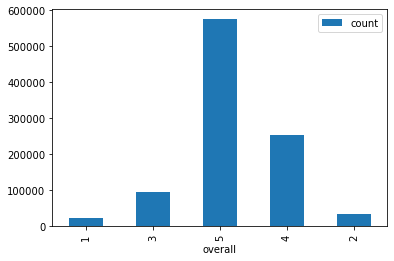

In [13]:
# Create a bar plot
to_pandas = overall_count.toPandas()

to_pandas.plot(x="overall", y="count", kind="bar")

In [10]:
def new_overall(value):
  if value in [4, 5]:
    return "good"
  elif value in [3, 2, 1]:
    return "bad"

from pyspark.sql.functions import udf
new_overall_udf = udf(new_overall)
data = data.withColumn("review", new_overall_udf("overall"))

In [12]:
data.show(20)

+--------------------+-------+------+
|          reviewText|overall|review|
+--------------------+-------+------+
|I enjoy vintage b...|      5|  good|
|This book is a re...|      4|  good|
|This was a fairly...|      4|  good|
|I'd never read an...|      5|  good|
|If you like perio...|      4|  good|
|A beautiful in-de...|      4|  good|
|I enjoyed this on...|      4|  good|
|Never heard of Am...|      4|  good|
|Darth Maul workin...|      5|  good|
|This is a short s...|      4|  good|
|I think I have th...|      5|  good|
|Title has nothing...|      4|  good|
|Well written. Int...|      3|   bad|
|Troy Denning's no...|      3|   bad|
|I am not for sure...|      5|  good|
|I really enjoyed ...|      5|  good|
|Great read enjoye...|      5|  good|
|Another well writ...|      3|   bad|
|This one promises...|      5|  good|
|"I have a version...|      4|  good|
+--------------------+-------+------+
only showing top 20 rows



In [20]:
review_count = data.groupBy("review").count()

review_count.show()

+------+------+
|review| count|
+------+------+
|   bad|153341|
|  good|829256|
+------+------+



In [11]:
from pyspark.sql.functions import regexp_replace

data = data.withColumn("Text", regexp_replace("reviewText", "[^a-zA-Z\\s]", ""))

data = data.withColumn("ReviewText", regexp_replace("Text", "\\b\\d+\\b", ""))

In [18]:
data.show(50)

+--------------------+-------+------+--------------------+
|          ReviewText|overall|review|                Text|
+--------------------+-------+------+--------------------+
|I enjoy vintage b...|      5|  good|I enjoy vintage b...|
|This book is a re...|      4|  good|This book is a re...|
|This was a fairly...|      4|  good|This was a fairly...|
|Id never read any...|      5|  good|Id never read any...|
|If you like perio...|      4|  good|If you like perio...|
|A beautiful indep...|      4|  good|A beautiful indep...|
|I enjoyed this on...|      4|  good|I enjoyed this on...|
|Never heard of Am...|      4|  good|Never heard of Am...|
|Darth Maul workin...|      5|  good|Darth Maul workin...|
|This is a short s...|      4|  good|This is a short s...|
|I think I have th...|      5|  good|I think I have th...|
|Title has nothing...|      4|  good|Title has nothing...|
|Well written Inte...|      3|   bad|Well written Inte...|
|Troy Dennings nov...|      3|   bad|Troy Dennings nov..

In [12]:
data = data.drop('overall')
data=data.drop('Text')
data.show(5)

+--------------------+------+
|          ReviewText|review|
+--------------------+------+
|I enjoy vintage b...|  good|
|This book is a re...|  good|
|This was a fairly...|  good|
|Id never read any...|  good|
|If you like perio...|  good|
+--------------------+------+
only showing top 5 rows



In [13]:
from pyspark.ml.feature import RegexTokenizer,  CountVectorizer

Tokenization = RegexTokenizer(inputCol="ReviewText", outputCol="review_token", pattern="\\W")

In [14]:
countVectors = CountVectorizer(inputCol="review_token", outputCol="features",vocabSize=15000, minDF=5)

In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
label_stringIdx = StringIndexer(inputCol = "review", outputCol = "label")

pipeline = Pipeline(stages=[Tokenization,  countVectors,label_stringIdx])

In [16]:
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------------+------+--------------------+--------------------+-----+
|          ReviewText|review|        review_token|            features|label|
+--------------------+------+--------------------+--------------------+-----+
|I enjoy vintage b...|  good|[i, enjoy, vintag...|(15000,[0,1,2,3,4...|  0.0|
|This book is a re...|  good|[this, book, is, ...|(15000,[0,1,2,3,4...|  0.0|
|This was a fairly...|  good|[this, was, a, fa...|(15000,[0,1,2,3,4...|  0.0|
|Id never read any...|  good|[id, never, read,...|(15000,[0,4,5,7,1...|  0.0|
|If you like perio...|  good|[if, you, like, p...|(15000,[0,5,7,16,...|  0.0|
+--------------------+------+--------------------+--------------------+-----+
only showing top 5 rows



In [17]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

In [18]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(maxIter=10, regParam=0.1,labelCol="label", featuresCol="features")

In [19]:
Model = svm.fit(trainingData)


In [20]:
predictions = Model.transform(testData)


In [44]:
predictions.printSchema()

root
 |-- ReviewText: string (nullable = true)
 |-- review: string (nullable = true)
 |-- review_token: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [26]:
predictions.filter(predictions['prediction'] == 1) \
    .select("reviewText","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+-----+----------+
|                    reviewText|label|prediction|
+------------------------------+-----+----------+
|   reading eBooks is changi...|  0.0|       1.0|
|  It just did not hold my i...|  1.0|       1.0|
|  Nice story Absolutely lov...|  0.0|       1.0|
|  No spoilers  An epic fant...|  1.0|       1.0|
|  Older alpha male  check  ...|  1.0|       1.0|
|  STARS ROUNDED UP TO TWO F...|  1.0|       1.0|
|  Stars Being a courier for...|  0.0|       1.0|
|  Stars Its innocent if sli...|  0.0|       1.0|
|  Stars She lives She dies ...|  0.0|       1.0|
|  Stars She witnessed a pow...|  0.0|       1.0|
+------------------------------+-----+----------+
only showing top 10 rows



In [25]:
predictions.filter(predictions['prediction'] == 0) \
    .select("reviewText","label","prediction") \
    .show(n = 10, truncate = 50)

+--------------------------------------------------+-----+----------+
|                                        reviewText|label|prediction|
+--------------------------------------------------+-----+----------+
|   Keeping relevant information from my readers...|  1.0|       0.0|
|   but if youre able to suspend disbelief smoki...|  0.0|       0.0|
|   but thats obviously deliberate Ive heard oth...|  0.0|       0.0|
|   over earlier New American BiblesAnd has Dire...|  0.0|       0.0|
|  A Well Developed Long Term RelationshipMilita...|  0.0|       0.0|
|  A high school girl is struggling to get along...|  1.0|       0.0|
|  Get this for your study in  it will help your...|  0.0|       0.0|
|  Potential Spoiler In comparison to some other...|  1.0|       0.0|
|  STARS After I readThe Abbeya few weeks ago I ...|  0.0|       0.0|
|  Stars Former professional tennis player Chris...|  0.0|       0.0|
+--------------------------------------------------+-----+----------+
only showing top 10 

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8907667212273079

In [22]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

In [23]:
y_true = predictions.select("label")
y_true = y_true.toPandas()
y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)

[[238585   9956]
 [ 20543  25396]]


In [24]:
print(classification_report(y_true,y_pred))


              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94    248541
         1.0       0.72      0.55      0.62     45939

    accuracy                           0.90    294480
   macro avg       0.82      0.76      0.78    294480
weighted avg       0.89      0.90      0.89    294480



In [65]:

from pyspark.ml.classification import NaiveBayes
Nb= NaiveBayes()
model =Nb.fit(trainingData)

In [66]:
predictions_nb = model.transform(testData)

In [71]:
predictions.filter(predictions['prediction'] == 0) \
    .select("reviewText","label","prediction") \
    .show(n = 10, truncate = 30)


+------------------------------+-----+----------+
|                    reviewText|label|prediction|
+------------------------------+-----+----------+
|   Keeping relevant informa...|  1.0|       0.0|
|   but if youre able to sus...|  0.0|       0.0|
|   but thats obviously deli...|  0.0|       0.0|
|   over earlier New America...|  0.0|       0.0|
|  A Well Developed Long Ter...|  0.0|       0.0|
|  A high school girl is str...|  1.0|       0.0|
|  Get this for your study i...|  0.0|       0.0|
|  It just did not hold my i...|  1.0|       0.0|
|  Nice story Absolutely lov...|  0.0|       0.0|
|  Older alpha male  check  ...|  1.0|       0.0|
+------------------------------+-----+----------+
only showing top 10 rows



In [73]:
evaluator_nb = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_nb.evaluate(predictions_nb)

0.8681061359147939

In [74]:
y_true_nb = predictions_nb.select("label")
y_true_nb = y_true_nb.toPandas()
y_pred_nb = predictions_nb.select("prediction")
y_pred_nb = y_pred_nb.toPandas()

confusion_mat_nb = confusion_matrix(y_true_nb, y_pred_nb)
print(confusion_mat_nb)

[[218710  29831]
 [ 11648  34291]]


In [75]:
print(classification_report(y_true_nb,y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91    248541
         1.0       0.53      0.75      0.62     45939

    accuracy                           0.86    294480
   macro avg       0.74      0.81      0.77    294480
weighted avg       0.88      0.86      0.87    294480

